In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import ode, odeint, solve_ivp
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks

Material properties

In [2]:
sm = 3e9                   # Shear modulus (Pa)
density = 916              # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # The radiation damping coefficient (kg / (m^2 * s))
L = 100                    # Width of fault patch (m)
k = sm / L                 # spring constant (Pa / m)
Vp = 3.96372e-6            # Rate of loading ~ 125m/d

Regularized rate and state friction law with the aging law and parameter choices 

In [3]:
# overburden = 916*600*9.8
sigma_n = 0.8e6   # Normal stress (Pa)
a = 0.005         # direct velocity strengthening effect
b = 0.015         # state-based velocity weakening effect
Dc = 1e-6         # state evolution length scale (m)
f0 = 0.6          # baseline coefficient of friction
V0 = 1e-3           # when V = V0, f = f0, V is (m/s)

# Rate-state friction law w/ Rice et al 2001 regularization so that 
# it is nonsingular at V = 0
def F(V, state):
    return a * np.arcsinh(V / (2 * V0) * np.exp(state / a))

# State evolution law -- aging law.
def G(V, state):
    return (b * V0 / Dc) * (np.exp((f0 - state) / b) - (V / V0))

# Define a diurnal effective normal stress
sigma_diurnal = 0.6e6
def sigma(t):
    return sigma_n - sigma_diurnal * np.sin(2*np.pi*t / 86400)

def load(t):
#     load_diurnal = 3.96372e-6 / 2
#     return Vp + load_diurnal * np.sin(2*np.pi*t / 86400)
    return Vp

If $k/k_{crit} < 1$, the system is said to be "unstable" and stick slip cycles occur.

In [4]:
kcrit = sigma_n * (b-a) / Dc 
print('k/kcrit =', k / kcrit)

period_at_neutral_stability = 2*np.pi/(np.sqrt((b-a)/a) * Vp / Dc)
print('Minimum period = %f s'%period_at_neutral_stability)

period_from_stress_drop =  ((b-a)*sigma_n) /( k * Vp )
print('Period from stress drop = %f s'%period_from_stress_drop)

k/kcrit = 0.0037500000000000003
Minimum period = 1.120887 s
Period from stress drop = 67.276868 s


**Initial conditions**

In [5]:
x_0 = 0.0 # slider position
y_0 = 0.0 # load point position
V_slider_0 = Vp / 1000.0 # Initially, the slider is moving at 1/1000th the loading rate.

Set the state variable initial condition by solving for the steady-state state variable given the initial velocity. That just involves solving for the value of `state` at which `G(V, state) = 0`. 

In [6]:
def steady_state(V_slider):
    def f(state):
        return G(V_slider, state)
    return fsolve(f, 0.0)[0]
state_0 = steady_state(V_slider_0)

/home/bpl7/.local/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


At each time step solve an algebraic equation for the current velocity, 
$ \tau = \eta V +  F(V, \sigma_n, state)$

In [7]:
def current_vel(t,tau_qs, state, V_slider_old):
    '''
    Solve for the current state using the velocity from the previous time step
    '''
    def f(V):
        return tau_qs - eta * V - sigma(t)*F(V, state)
    return fsolve(f, V_slider_old)[0]

Define the derivatives

In [8]:
def f(t, x_and_state_and_y):
    x, state, y = x_and_state_and_y
    # The position of the load point.
#     y = Vp * t
    dydt = load(t)
    
    # The extensional force of our spring 
    tau_qs = k * (y - x) 
    
    # Solve for the current velocity
    V_slider = current_vel(t,tau_qs, state, f.V_slider_old) 
    
    # Store the velocity to use it next nonlinear solve initial guess
    f.V_slider_old = V_slider 
    
    dxdt = V_slider
    dstatedt = G(V_slider, state)
#     print(t)
    return [dxdt, dstatedt, dydt]
f.V_slider_old = V_slider_0

Define the initial conditions:

In [9]:
initial_conditions = np.array([x_0, state_0, y_0])

And actually solve the equations!

In [10]:
# time_span = (0, period_from_stress_drop * 200 )
time_span = (0, 86400 * 2)
wall_clock_start_time = time.time()
history = solve_ivp(f, time_span, initial_conditions, rtol=1e-9, atol=1e-9,method='LSODA')
time.time() - wall_clock_start_time

# For a particular trial problem that I set up:
# BDF took 75 s, 
# RK45 (default) took 85 s,
# Radau crashed,
# LSODA took 28 s

38.26636338233948

In [11]:
h_x = history.y[0,:]
h_state = history.y[1,:]
h_V = (h_x[1:] - h_x[:-1]) / (history.t[1:] - history.t[:-1])
h_y = history.t * Vp
h_tau_qs = k * (h_y - h_x)
h_tau_qd = h_tau_qs[1:] - eta * h_V

Finally, I'll plot up the results.

In [12]:
# #plt.style.use('dark_background')
# # %config InlineBackend.figure_format = 'retina'
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 22
# # plt.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}'

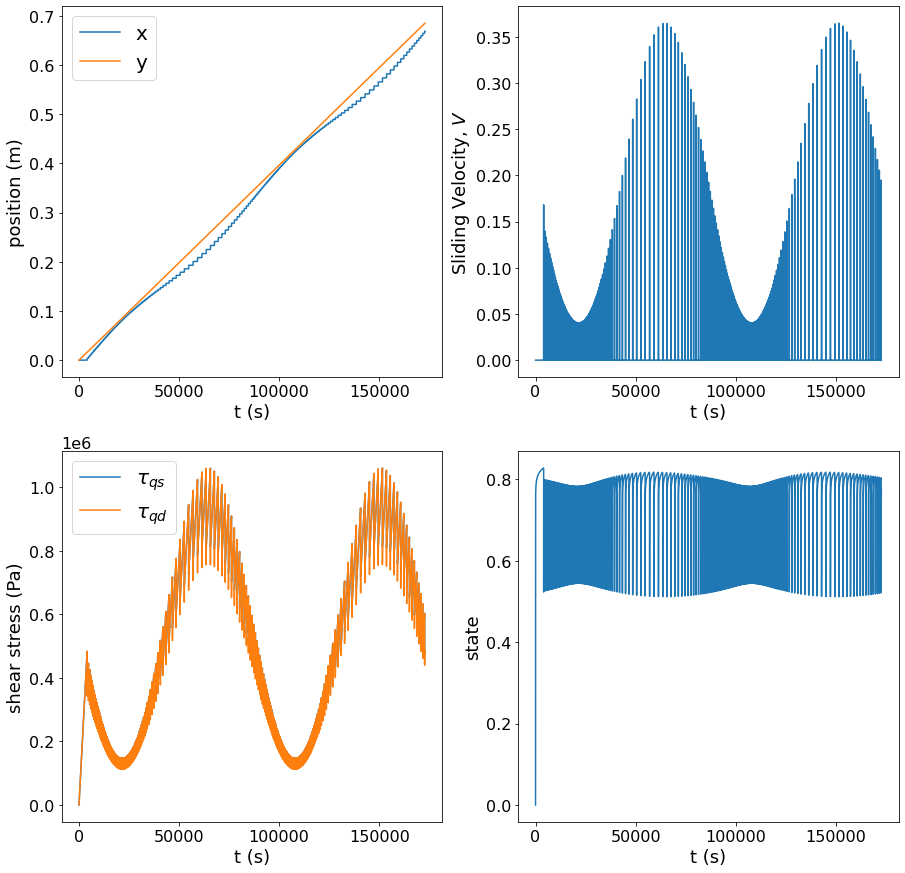

In [13]:
fig,ax = plt.subplots(figsize = (15, 15))
fig.patch.set_facecolor('white')
ax11 = plt.subplot(221)
plt.plot(history.t, h_x, label = 'x')
plt.plot(history.t, h_y, label = 'y')
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.legend()

ax12 = plt.subplot(222)
plt.plot(history.t[1:], h_V)
plt.xlabel('t (s)')
plt.ylabel('Sliding Velocity, $V$')
plt.subplot(223, sharex = ax11)
plt.plot(history.t, h_tau_qs, label = '$\\tau_{qs}$')
plt.plot(history.t[1:], h_tau_qd, label = '$\\tau_{qd}$')
plt.xlabel('t (s)')
plt.ylabel('shear stress (Pa)')
plt.legend()
plt.subplot(224)
plt.plot(history.t, h_state)
plt.xlabel('t (s)')
plt.ylabel('state')
# plt.savefig('qd_1d.pdf', bbox_inches = 'tight')
# plt.savefig('qd_1d.png', bbox_inches = 'tight', dpi = 200)
plt.show()

In [14]:
history

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 432544
     njev: 8771
      nlu: 8771
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.29477686e-24, 2.58955372e-24, ...,
       1.72789554e+05, 1.72795108e+05, 1.72800000e+05])
 t_events: None
        y: array([[0.00000000e+00, 7.04243359e-53, 2.11182009e-52, ...,
        6.68716682e-01, 6.68716682e-01, 6.68716682e-01],
       [0.00000000e+00, 4.57017830e-06, 9.13896479e-06, ...,
        7.73961207e-01, 7.74707907e-01, 7.75336124e-01],
       [0.00000000e+00, 5.13213293e-30, 1.02642659e-29, ...,
        6.84889413e-01, 6.84911427e-01, 6.84930816e-01]])
 y_events: None

Text(0, 0.5, 'Sliding rate (m/s)')

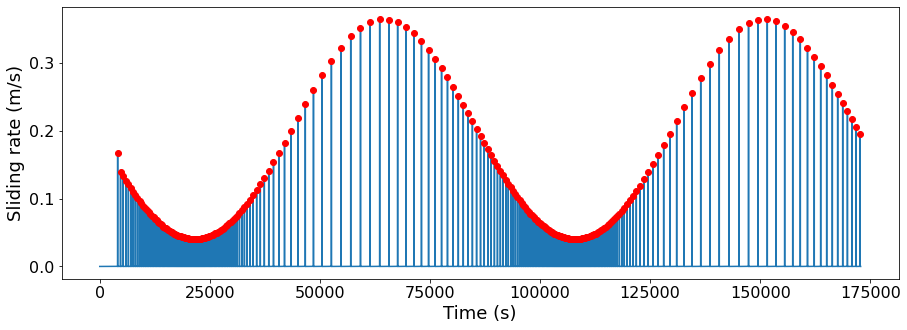

In [15]:


peaks, _ = find_peaks(h_V,height=max(h_V)/100,distance=400)
fig, ax = plt.subplots(figsize = (15, 5))
fig.patch.set_facecolor('white')
plt.plot(history.t[1:], h_V)
plt.plot(history.t[peaks], h_V[peaks],'or')
# plt.yscale('log')
# plt.ylim((1e-10,1))
plt.xlabel('Time (s)')
plt.ylabel('Sliding rate (m/s)')

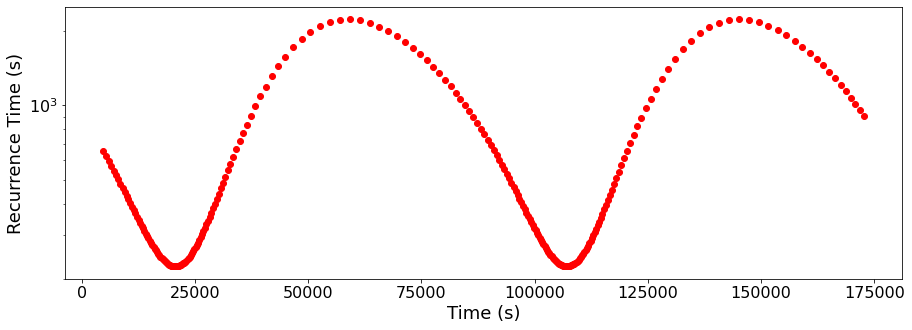

In [16]:
fig, ax = plt.subplots(figsize = (15, 5))
fig.patch.set_facecolor('white')
plt.plot(history.t[peaks[1:]],np.diff(history.t[peaks]),'or')
plt.ylabel('Recurrence Time (s)')
plt.xlabel('Time (s)')
plt.yscale('log')

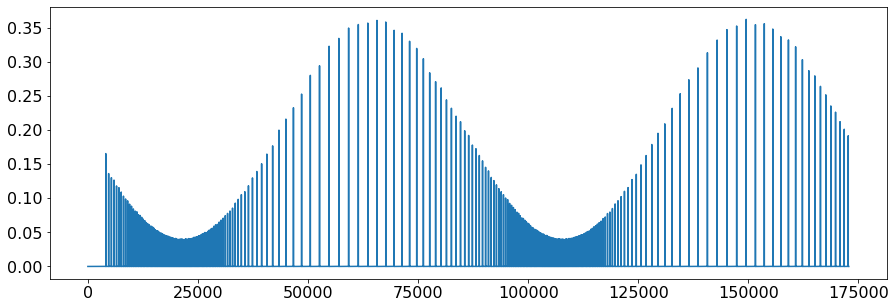

In [17]:
from scipy import interpolate
f = interpolate.interp1d(history.t[1:], h_V)
t_new = np.arange(min(history.t[1:]), max(history.t[1:]), 1e-3)
V_new = f(t_new)   # use interpolation function returned by `interp1d`
fig, ax = plt.subplots(figsize = (15, 5))
fig.patch.set_facecolor('white')
plt.plot(t_new, V_new, '-')
plt.show()

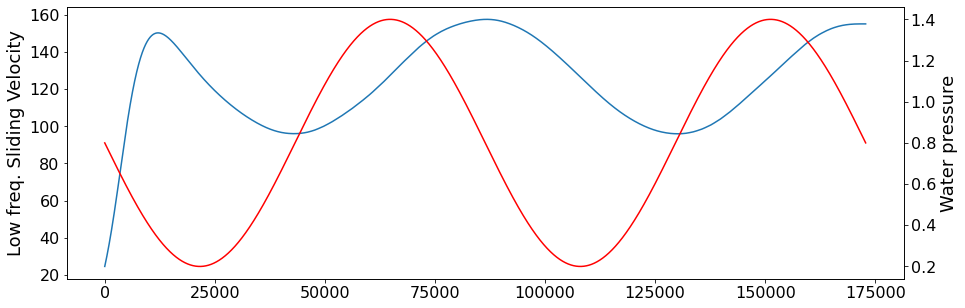

In [19]:
from scipy import signal

b, a = signal.butter(2, 1e-7, 'low')

filtered = signal.filtfilt(b, a, V_new)
fig, ax1 = plt.subplots(figsize = (15, 5))
fig.patch.set_facecolor('white')
plt.plot(t_new[::1000], filtered[::1000] * 86400 * 365)
ax1.set_ylabel('Low freq. Sliding Velocity')
ax2 = ax1.twinx()
plt.plot(t_new[::1000],sigma(t_new[::1000])/1e6,'-r')
ax2.set_ylabel('Water pressure')
plt.show()